In [1]:
import json
from pathlib import Path
import pandas as pd

In [7]:
def load_json_to_dataframe(folder: str) -> pd.DataFrame:
    """
    Load all JSON files from a folder, convert them to DataFrames, 
    add a 'file' column with the filename, and concatenate into a single DataFrame.
    """
    dfs = []
    
    for file in Path(folder).glob("*.json"):
        with open(file, 'r', encoding='utf-8') as f:
            records = json.load(f)
        
        temp_df = pd.DataFrame(records)
        temp_df['file'] = file.stem
        dfs.append(temp_df)
    
    if dfs:
        return pd.concat(dfs, ignore_index=True)
    else:
        return pd.DataFrame()  

In [8]:
data_bc = load_json_to_dataframe("data/01_extracted")
data_ac = load_json_to_dataframe("data/03_chunked")

In [10]:
data_bc.head()

,url,type,depth,text,file
0,https://eur-lex.europa.eu/PT/legal-content/sum...,html,0,× Skip to main content Log in My EUR-Lex My EU...,FTJ
1,https://eur-lex.europa.eu/PT/legal-content/sum...,html,1,× Skip to main content Log in My EUR-Lex My EU...,FTJ
2,https://eur-lex.europa.eu/legal-content/PT/TXT...,html,1,× Skip to main content Log in My EUR-Lex My EU...,FTJ
3,https://eur-lex.europa.eu/PT/legal-content/glo...,html,1,× Skip to main content Log in My EUR-Lex My EU...,FTJ
4,https://eur-lex.europa.eu/PT/legal-content/glo...,html,1,× Skip to main content Log in My EUR-Lex My EU...,FTJ


In [11]:
data_ac.head()

,url,chunk_id,fingerprint,content,file
0,https://eur-lex.europa.eu/PT/legal-content/sum...,0.0,b33bd1859b85ebeb6f01ffe882cef2f2,Regulamento (UE) 2021/1056 que cria o Fundo pa...,FTJ
1,https://eur-lex.europa.eu/PT/legal-content/sum...,1.0,e55eb38b7e831a3a0b496f3c3d6bc87c,. PONTOS-CHAVE O FTJ visa contribuir para o ob...,FTJ
2,https://eur-lex.europa.eu/PT/legal-content/sum...,2.0,8dd7884b1dfa01ea56276864f5e60a28,". Pode, além disso, apoiar investimentos que c...",FTJ
3,https://eur-lex.europa.eu/PT/legal-content/sum...,3.0,1b3d86e7fc2c8756314aa376c44dd9c3,. Âmbito de aplicação O FTJ apoia o investimen...,FTJ
4,https://eur-lex.europa.eu/PT/legal-content/sum...,4.0,72f6720ef99ffcdc5da26054523f2116,", incluindo a descarbonização do setor dos tra...",FTJ


Word count per line

In [12]:
data_bc['word_count'] = data_bc["text"].str.split().str.len()
data_ac['word_count'] = data_ac["content"].str.split().str.len()

**URLs**

In [13]:
data_bc["url"].nunique()

846

In [14]:
data_ac["url"].nunique()

818

**Statistics**

In [35]:
def summarize_text_stats(df, text_col="text", file_col="file", page_col="url"):
    """
    Generate summary statistics for a text dataset.

    """

    # Aggregate at page level to normalize chunking
    page_stats = df.groupby([file_col, page_col]).agg(
        words_per_page=('word_count', 'sum'),
        chunks_per_page=('word_count', 'count')  
    ).reset_index()
    
    # Summary per file
    summary = page_stats.groupby(file_col).agg(
        total_pages=(page_col, 'count'),          # number of original pages
        total_words=('words_per_page', 'sum'),    # sum of all words
        avg_words=('words_per_page', 'mean'),     # avg words per page
        std_words=('words_per_page', 'std'),      # std dev per page
        avg_chunks_per_page=('chunks_per_page', 'mean')  # avg chunks per page (optional)
    ).reset_index()
    
    # Overall stats
    overall = pd.DataFrame({
        file_col: ['Overall'],
        'total_pages': [summary['total_pages'].sum()],
        'total_words': [summary['total_words'].sum()],
        'avg_words': [page_stats['words_per_page'].mean()],
        'std_words': [page_stats['words_per_page'].std()],
        'avg_chunks_per_page': [page_stats['chunks_per_page'].mean()]
    })
    
    summary_df = pd.concat([summary, overall], ignore_index=True)
    
    return summary_df


In [36]:
summarize_text_stats(data_bc)

,file,total_pages,total_words,avg_words,std_words,avg_chunks_per_page
0,FAMI,7,13330,1904.285714,1075.283639,1.142857
1,FEDER_pt2030,11,7608,691.636364,392.209452,1.000000
2,FTJ,17,64885,3816.764706,4477.566031,1.058824
3,IGFV,11,18103,1645.727273,865.118615,1.090909
4,alentejo_portugal2030,28,14534,519.071429,270.932126,1.000000
5,algarve_portugal2030,56,28380,506.785714,508.807830,1.000000
6,centro2030,30,14643,488.100000,309.973564,1.033333
7,compete2030,241,187141,776.518672,383.665078,1.000000
8,european-social-fund,1,432,432.000000,NaN,1.000000
9,lisboa_portugal2030,70,51902,741.457143,538.932700,1.014286


In [37]:
summarize_text_stats(data_ac, "content")

,file,total_pages,total_words,avg_words,std_words,avg_chunks_per_page
0,FAMI,5,5117,1023.400000,569.855947,21.600000
1,FEDER_pt2030,11,7043,640.272727,450.065127,13.363636
2,FTJ,10,47271,4727.100000,5497.466557,103.300000
3,IGFV,7,5414,773.428571,164.872534,18.000000
4,alentejo_portugal2030,28,10878,388.500000,281.991791,8.678571
5,algarve_portugal2030,48,19334,402.791667,516.859747,9.270833
6,centro2030,29,11326,390.551724,318.996259,9.103448
7,compete2030,237,133171,561.902954,364.683510,12.894515
8,lisboa_portugal2030,66,27485,416.439394,467.721157,9.242424
9,norte2030,46,43411,943.717391,1690.611101,21.608696


In [40]:
from collections import Counter
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

stop_words = set(stopwords.words('portuguese'))  # adapt if your text is in another language


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/antoniooliveira/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [41]:
def get_most_common_words(df, text_col="text", file_col=None, top_n=20, remove_stopwords=True):
    def process_text(text):
        words = re.findall(r'\b\w+\b', str(text).lower())
        if remove_stopwords:
            words = [w for w in words if w not in stop_words]
        return words
    
    if file_col:
        result = {}
        for f, group in df.groupby(file_col):
            all_words = []
            for text in group[text_col]:
                all_words.extend(process_text(text))
            result[f] = Counter(all_words).most_common(top_n)
        return result
    else:
        all_words = []
        for text in df[text_col]:
            all_words.extend(process_text(text))
        return Counter(all_words).most_common(top_n)


In [49]:
common_words_bc = get_most_common_words(data_bc)

In [48]:
common_words_ac = get_most_common_words(data_ac, text_col="content")

In [60]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_most_common_words(common_words, title="Most Common Words"):

    words, counts = zip(*common_words)
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x=list(words), y=list(counts))
    plt.xlabel("Frequency")
    plt.ylabel("Word")
    plt.title(title)
    plt.xticks(rotation=45) 
    plt.show()


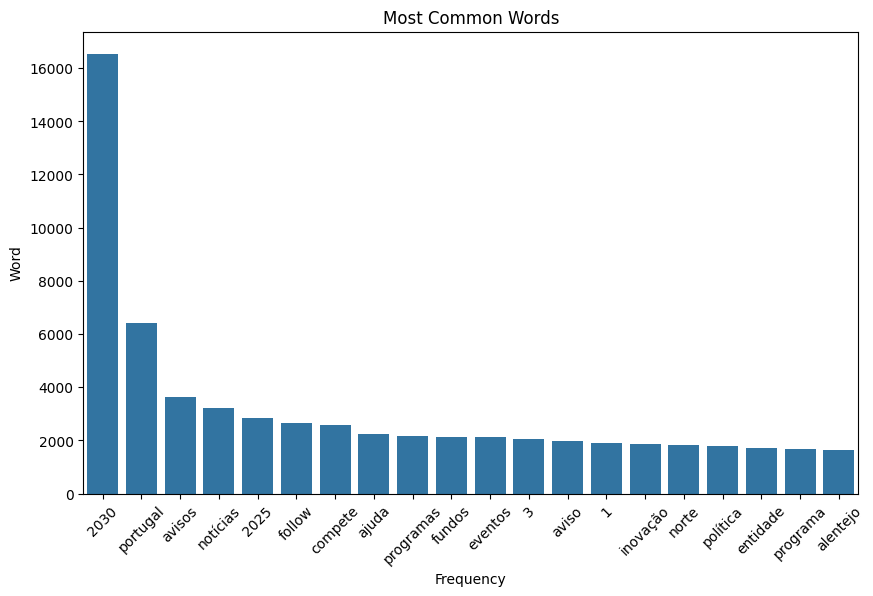

In [61]:
plot_most_common_words(common_words_bc)

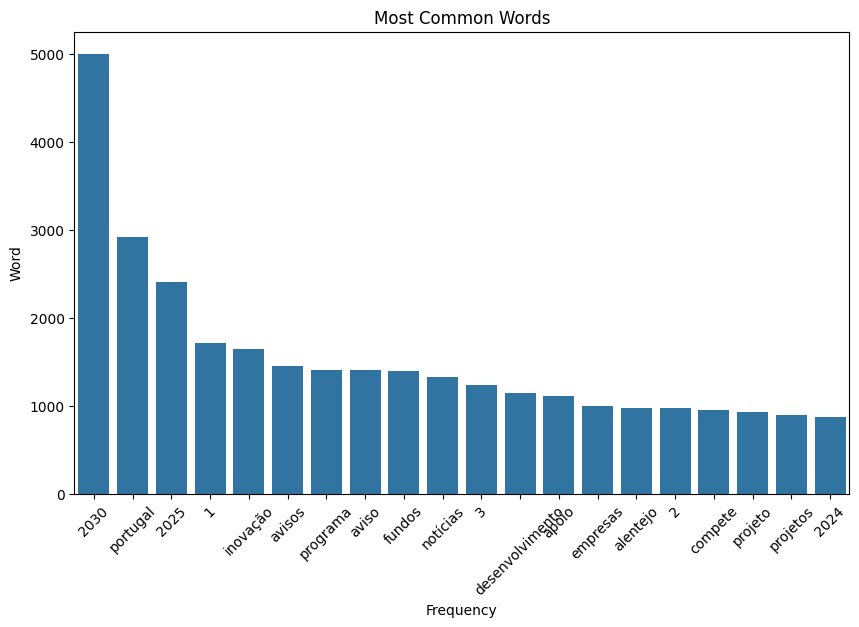

In [62]:
plot_most_common_words(common_words_ac)

In [22]:
grouped_ac.describe()

,total_pages,avg_words,std_words
count,11.000000,11.000000,11.000000
mean,903.818182,44.712441,15.122958
std,1079.795149,1.701833,1.127481
min,108.000000,42.901515,12.799586
25%,195.000000,43.512044,14.758599
50%,445.000000,44.395062,15.347578
75%,1013.500000,45.409134,15.900070
max,3056.000000,47.911565,16.391204


In [9]:
df['word_count'].sum()

np.int64(656092)